# Deterministic fitting of epidemiological models on Italian COVID-19 cases

All the following models are fitted on disjoint windows.
After fitting, predictions are plotted for the entire dataset (about 1 year), RMSE is computed as a (crude) evaluation metric and the fitted parameters are exported as csv in order to be used as seeds for the Bayesian melding.

In [82]:
from scipy.optimize import curve_fit
import numpy as np
import math
from matplotlib import pyplot as plt
import pandas as pd

import models

def rmse(true, pred):
    out = 0
    for i in range(len(true)):
        out += (true[i] - pred[i]) ** 2
    return (out / len(true)) ** 0.5

window_size = 7

## SIR model

                 data stato  ricoverati_con_sintomi  terapia_intensiva  \
0 2020-02-24 18:00:00   ITA                     101                 26   
1 2020-02-25 18:00:00   ITA                     114                 35   
2 2020-02-26 18:00:00   ITA                     128                 36   
3 2020-02-27 18:00:00   ITA                     248                 56   
4 2020-02-28 18:00:00   ITA                     345                 64   

   totale_ospedalizzati  isolamento_domiciliare  totale_positivi  \
0                   127                      94              221   
1                   150                     162              311   
2                   164                     221              385   
3                   304                     284              588   
4                   409                     412              821   

   variazione_totale_positivi  nuovi_positivi  dimessi_guariti  ...  tamponi  \
0                           0             221                1  ..

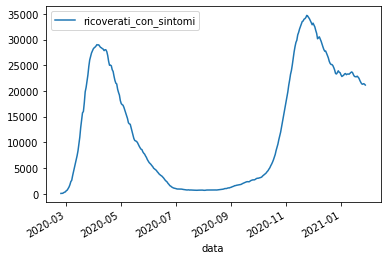

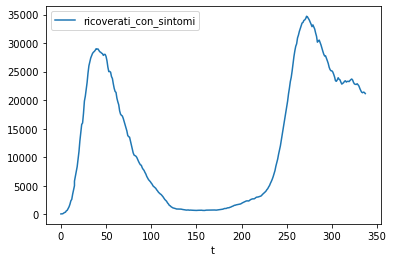

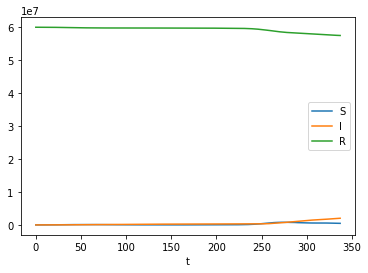

In [83]:
df = pd.read_csv("dpc-covid19-ita-andamento-nazionale.csv", parse_dates=["data"]) # 28/01/2021. Entire dataset.

print(df.head())

df.plot.line("data", "ricoverati_con_sintomi")

df["t"] = (df["data"] - df["data"].loc[0]) // np.timedelta64(1, "D")

print(df[["data", "t"]].head())

df.plot.line("t", "ricoverati_con_sintomi")
dataset = pd.DataFrame() # Dataset containing only the relevant fields for the SIR model.
dataset["t"] = df["t"]
dataset["i"] = df["totale_positivi"]
dataset["r"] = df["dimessi_guariti"] + df["deceduti"]
dataset["s"] = 60000000 - (dataset["i"] + dataset["r"])

dataset = dataset.set_index("t")

dataset.plot.line()
plt.legend(["S", "I", "R"])

print(dataset.head())


In order for curve_fit to work correctly, inputs and outputs need to be passed as lists. To solve this problem, the `Model.f(...)` proxy needs to be used along with a sequence of inputs from $0$ to $t$.

In [84]:
my_sir = models.SIR()

means = {}
variances = {}
for i in range(len(dataset) // window_size):
    print("Fitting window {}-{}...".format(i * window_size, (i+1) * window_size))
    x_data = np.array([j for j in range(window_size)], dtype=np.uint8)
    y_data = np.zeros((window_size, 3), dtype=np.float)
    for j in range(window_size):
        y_data[j,0] = dataset["s"].iloc[i * window_size + j]
        y_data[j,1] = dataset["i"].iloc[i * window_size + j]
        y_data[j,2] = dataset["r"].iloc[i * window_size + j]
        
    initial_guess = [dataset["s"].iloc[i * window_size], dataset["i"].iloc[i * window_size], dataset["r"].iloc[i * window_size], 0.5, 0.5]
    vals, confidences = curve_fit(my_sir.f, x_data, y_data.flatten(), initial_guess, bounds=([0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, 1, 1]))
    keys = my_sir.get_input_keys()
    for k in range(len(keys)):
        my_sir.input_params[keys[k]] = vals[k]
        
    for k in range(len(keys)):
        if keys[k] not in means:
            means[keys[k]] = []
        means[keys[k]].append(vals[k])
        if keys[k] not in variances:
            variances[keys[k]] = []
        variances[keys[k]].append(confidences[k])

Fitting window 0-7...
Fitting window 7-14...
Fitting window 14-21...
Fitting window 21-28...
Fitting window 28-35...
Fitting window 35-42...
Fitting window 42-49...
Fitting window 49-56...
Fitting window 56-63...
Fitting window 63-70...


<ipython-input-84-3a165790b8ae>:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_data = np.zeros((window_size, 3), dtype=np.float)


Fitting window 70-77...
Fitting window 77-84...
Fitting window 84-91...
Fitting window 91-98...
Fitting window 98-105...
Fitting window 105-112...
Fitting window 112-119...
Fitting window 119-126...
Fitting window 126-133...
Fitting window 133-140...
Fitting window 140-147...
Fitting window 147-154...
Fitting window 154-161...
Fitting window 161-168...
Fitting window 168-175...
Fitting window 175-182...
Fitting window 182-189...
Fitting window 189-196...
Fitting window 196-203...
Fitting window 203-210...
Fitting window 210-217...
Fitting window 217-224...
Fitting window 224-231...
Fitting window 231-238...
Fitting window 238-245...
Fitting window 245-252...
Fitting window 252-259...
Fitting window 259-266...
Fitting window 266-273...
Fitting window 273-280...
Fitting window 280-287...
Fitting window 287-294...
Fitting window 294-301...
Fitting window 301-308...
Fitting window 308-315...
Fitting window 315-322...
Fitting window 322-329...
Fitting window 329-336...


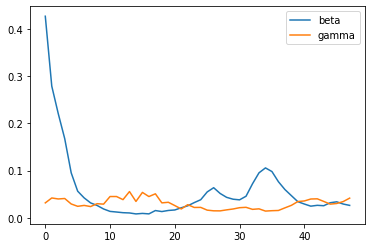

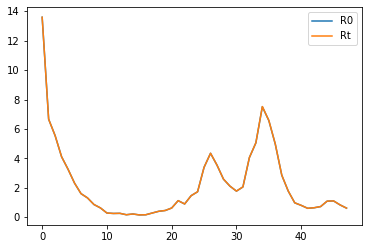

<ipython-input-85-802b8e255179>:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.plot(range(0, len(means["S0"])), np.array(means["S0"], dtype=np.float) * 10**-2)


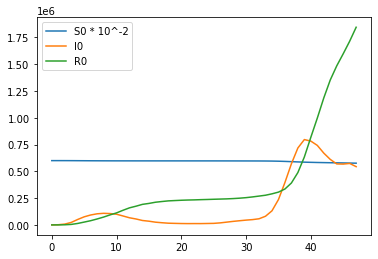

In [85]:
plt.plot(range(0, len(means["beta"])), means["beta"])
plt.plot(range(0, len(means["gamma"])), means["gamma"])
plt.legend(["beta", "gamma"])
plt.show()

r0 = [means["beta"][i] / means["gamma"][i] for i in range(len(means["beta"]))]
rt = []
for i in range(len(r0)):
    n = dataset.iloc[i]["s"] + dataset.iloc[i]["i"] + dataset.iloc[i]["r"]
    s = dataset.iloc[i]["s"]
    rt.append(r0[i] * n / s)
plt.plot(range(0, len(r0)), r0)
plt.plot(range(0, len(rt)), rt)
plt.legend(["R0", "Rt"])
plt.show()

plt.plot(range(0, len(means["S0"])), np.array(means["S0"], dtype=np.float) * 10**-2)
plt.plot(range(0, len(means["I0"])), means["I0"])
plt.plot(range(0, len(means["R0"])), means["R0"])

plt.legend(["S0 * 10^-2", "I0", "R0"])

plt.show()

In [86]:
predictions = {}
in_keys = my_sir.get_input_keys()
out_keys = my_sir.get_output_keys()
for i in range(len(dataset) // window_size):
    for k in range(len(in_keys)):
        my_sir.input_params[in_keys[k]] = means[in_keys[k]][i]
    tmp = my_sir.eval_series(window_size - 1)
    
    for k in range(len(out_keys)):
        if out_keys[k] not in predictions:
            predictions[out_keys[k]] = []
        predictions[out_keys[k]].extend(tmp[out_keys[k]])

        

total_rmse = 0
tmp = rmse(dataset["s"].iloc[:len(predictions["S"])].values, predictions["S"])
print("RMS on S0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["i"].iloc[:len(predictions["S"])].values, predictions["I"])
print("RMS on I0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["r"].iloc[:len(predictions["S"])].values, predictions["R"])
print("RMS on R0: {}".format(tmp))
total_rmse += tmp
print("Total RMSE: {}".format(total_rmse))

RMS on S0: 1140.2724434509366
RMS on I0: 2076.2370742297912
RMS on R0: 2073.615904152814
Total RMSE: 5290.125421833542


<ipython-input-87-ac42c1d479c2>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.plot(range(0, len(predictions["S"])), np.array(predictions["S"], dtype=np.float) * 10**-2)
<ipython-input-87-ac42c1d479c2>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.plot(range(0, len(predictions["S"])), np.array(dataset["s"].iloc[:len(predictio

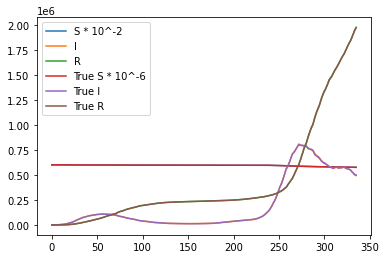

In [87]:
plt.plot(range(0, len(predictions["S"])), np.array(predictions["S"], dtype=np.float) * 10**-2)
plt.plot(range(0, len(predictions["I"])), predictions["I"])
plt.plot(range(0, len(predictions["R"])), predictions["R"])
plt.plot(range(0, len(predictions["S"])), np.array(dataset["s"].iloc[:len(predictions["S"])], dtype=np.float) * 10**-2)
plt.plot(range(0, len(predictions["I"])), dataset["i"].iloc[:len(predictions["S"])])
plt.plot(range(0, len(predictions["R"])), dataset["r"].iloc[:len(predictions["S"])])


plt.legend(["S * 10^-2", "I", "R", "True S * 10^-6", "True I", "True R"])

plt.show()

In [88]:
print(means)

{'S0': [59999776.00515532, 59998008.37418449, 59991124.611590244, 59972127.819534466, 59935516.39819222, 59898153.51307594, 59868045.38036114, 59840794.68164808, 59818570.12503391, 59800415.349158525, 59788106.04941394, 59779945.97518296, 59774050.25421851, 59769906.112283945, 59766823.15634, 59764778.379245885, 59762649.69384322, 59761288.36914195, 59759615.46569957, 59758241.689642124, 59756850.25098618, 59755445.5545703, 59753780.67492503, 59751908.52414368, 59749252.70608889, 59746120.22494117, 59739849.99657256, 59731029.25737611, 59721223.390692666, 59711459.204630524, 59700708.245261826, 59689194.16673179, 59673678.08372076, 59642075.574293405, 59578389.245520055, 59457425.17801788, 59269256.539922245, 59038371.82653274, 58793357.64055788, 58569622.73067262, 58400171.20388603, 58261153.58624619, 58145049.935520634, 58036205.840163514, 57946651.3575663, 57835175.2044092, 57711775.211592, 57611657.00286369], 'I0': [209.78957657208468, 1754.534075842438, 7660.726205683863, 23135.45

In [89]:
sir_params = pd.DataFrame(means)
sir_params = sir_params.reset_index()
sir_params = sir_params.rename(columns={"index":"t"})
dates = (sir_params["t"] * window_size).to_list()
sir_params["data"] = df["data"][dates].to_list()


print(sir_params.head())

sir_params.to_csv("sir_params_weekly.csv")

   t            S0            I0            R0      beta     gamma  \
0  0  5.999978e+07    209.789577     11.923035  0.426895  0.031425   
1  1  5.999801e+07   1754.534076    228.390698  0.278800  0.041829   
2  2  5.999112e+07   7660.726206   1216.327838  0.220608  0.039746   
3  3  5.997213e+07  23135.450291   4747.708232  0.167516  0.040703   
4  4  5.993552e+07  50833.950736  13657.926284  0.095110  0.029127   

                 data  
0 2020-02-24 18:00:00  
1 2020-03-02 18:00:00  
2 2020-03-09 18:00:00  
3 2020-03-16 17:00:00  
4 2020-03-23 17:00:00  


# SIRD fitting

     i   r   d         s
t                       
0  221   1   7  59999771
1  311   1  10  59999678
2  385   3  12  59999600
3  588  45  17  59999350
4  821  46  21  59999112


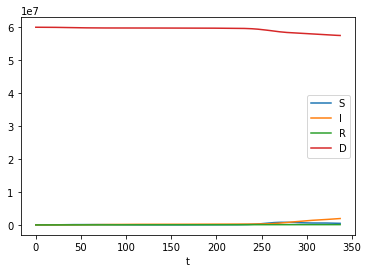

In [90]:
dataset = pd.DataFrame()
dataset["t"] = df["t"]
dataset["i"] = df["totale_positivi"]
dataset["r"] = df["dimessi_guariti"]
dataset["d"]= df["deceduti"]
dataset["s"] = 60000000 - (dataset["i"] + dataset["r"] + dataset["d"])

dataset = dataset.set_index("t")

dataset.plot.line()
plt.legend(["S", "I", "R", "D"])

print(dataset.head())

In [91]:
my_sird = models.SIRD()

means = {}
variances = {}
for i in range(len(dataset) // window_size):
    print("Fitting window {}-{}...".format(i * window_size, (i+1) * window_size))
    x_data = np.array([j for j in range(window_size)], dtype=np.uint8)
    y_data = np.zeros((window_size, 4), dtype=np.float)
    for j in range(window_size):
        y_data[j,0] = dataset["s"].iloc[i * window_size + j]
        y_data[j,1] = dataset["i"].iloc[i * window_size + j]
        y_data[j,2] = dataset["r"].iloc[i * window_size + j]
        y_data[j,3] = dataset["d"].iloc[i * window_size + j]

    initial_guess = [dataset["s"].iloc[i * window_size], dataset["i"].iloc[i * window_size], dataset["r"].iloc[i * window_size], dataset["d"].iloc[i * window_size], 0.5, 0.5, 0]
    vals, confidences = curve_fit(my_sird.f, x_data, y_data.flatten(), initial_guess, bounds=([0, 0, 0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, 1, 1, 1]))
    keys = my_sird.get_input_keys()
    for k in range(len(keys)):
        my_sird.input_params[keys[k]] = vals[k]
        
    for k in range(len(keys)):
        if keys[k] not in means:
            means[keys[k]] = []
        means[keys[k]].append(vals[k])
        if keys[k] not in variances:
            variances[keys[k]] = []
        variances[keys[k]].append(confidences[k])


Fitting window 0-7...
Fitting window 7-14...
Fitting window 14-21...
Fitting window 21-28...
Fitting window 28-35...
Fitting window 35-42...
Fitting window 42-49...
Fitting window 49-56...
Fitting window 56-63...
Fitting window 63-70...
Fitting window 70-77...
Fitting window 77-84...
Fitting window 84-91...
Fitting window 91-98...
Fitting window 98-105...


<ipython-input-91-8fa9d914ed24>:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_data = np.zeros((window_size, 4), dtype=np.float)


Fitting window 105-112...
Fitting window 112-119...
Fitting window 119-126...
Fitting window 126-133...
Fitting window 133-140...
Fitting window 140-147...
Fitting window 147-154...
Fitting window 154-161...
Fitting window 161-168...
Fitting window 168-175...
Fitting window 175-182...
Fitting window 182-189...
Fitting window 189-196...
Fitting window 196-203...
Fitting window 203-210...
Fitting window 210-217...
Fitting window 217-224...
Fitting window 224-231...
Fitting window 231-238...
Fitting window 238-245...
Fitting window 245-252...
Fitting window 252-259...
Fitting window 259-266...
Fitting window 266-273...
Fitting window 273-280...
Fitting window 280-287...
Fitting window 287-294...
Fitting window 294-301...
Fitting window 301-308...
Fitting window 308-315...
Fitting window 315-322...
Fitting window 322-329...
Fitting window 329-336...


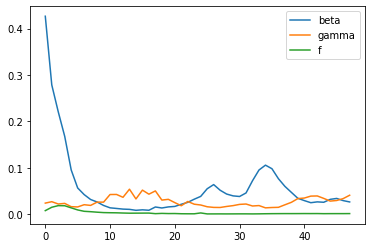

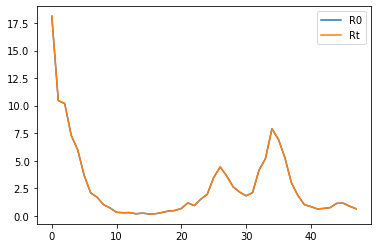

<ipython-input-92-fff9e663a471>:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.plot(range(0, len(means["S0"])), np.array(means["S0"], dtype=np.float) * 10**-2)


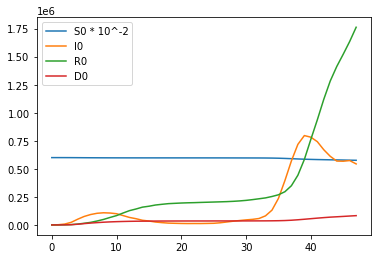

In [92]:
plt.plot(range(0, len(means["beta"])), means["beta"])
plt.plot(range(0, len(means["gamma"])), means["gamma"])
plt.plot(range(0, len(means["f"])), means["f"])

plt.legend(["beta", "gamma", "f"])
plt.show()

r0 = [means["beta"][i] / means["gamma"][i] for i in range(len(means["beta"]))]
rt = []
for i in range(len(r0)):
    n = dataset.iloc[i]["s"] + dataset.iloc[i]["i"] + dataset.iloc[i]["r"]
    s = dataset.iloc[i]["s"]
    rt.append(r0[i] * n / s)
plt.plot(range(0, len(r0)), r0)
plt.plot(range(0, len(rt)), rt)
plt.legend(["R0", "Rt"])
plt.show()

plt.plot(range(0, len(means["S0"])), np.array(means["S0"], dtype=np.float) * 10**-2)
plt.plot(range(0, len(means["I0"])), means["I0"])
plt.plot(range(0, len(means["R0"])), means["R0"])
plt.plot(range(0, len(means["D0"])), means["D0"])


plt.legend(["S0 * 10^-2", "I0", "R0", "D0"])

plt.show()

In [93]:
predictions = {}
in_keys = my_sird.get_input_keys()
out_keys = my_sird.get_output_keys()
for i in range(len(dataset) // window_size):
    for k in range(len(in_keys)):
        my_sird.input_params[in_keys[k]] = means[in_keys[k]][i]
    tmp = my_sird.eval_series(window_size - 1)
    
    for k in range(len(out_keys)):
        if out_keys[k] not in predictions:
            predictions[out_keys[k]] = []
        predictions[out_keys[k]].extend(tmp[out_keys[k]])

        

total_rmse = 0
tmp = rmse(dataset["s"].iloc[:len(predictions["S"])].values, predictions["S"])
print("RMS on S0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["i"].iloc[:len(predictions["S"])].values, predictions["I"])
print("RMS on I0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["r"].iloc[:len(predictions["S"])].values, predictions["R"])
print("RMS on R0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["d"].iloc[:len(predictions["S"])].values, predictions["D"])
print("RMS on D0: {}".format(tmp))
total_rmse += tmp
print("Total RMSE: {}".format(total_rmse))

RMS on S0: 1140.1318630355172
RMS on I0: 2076.1993817071148
RMS on R0: 2044.8081629676587
RMS on D0: 56.651813073605325
Total RMSE: 5317.791220783895


In [94]:
print(means["f"])

[0.0073352904142183276, 0.014637796329934205, 0.018131901787565925, 0.01787582444262743, 0.013327133114962291, 0.00886119805114028, 0.005905023836573452, 0.005058131262660329, 0.003994103350160181, 0.0031219616543733115, 0.002822652543402882, 0.0026353006752394695, 0.002179405273009079, 0.0018241462548636489, 0.0019138530018732603, 0.001993906864304035, 0.002071783639079825, 0.0008342353729410982, 0.0013870393807880884, 0.0010193436519202327, 0.001097551757638587, 0.0006355709321673469, 0.0005334654017429368, 0.0005143500295948896, 0.0023749062652837502, 0.00026396825773759196, 0.0002872407414428901, 0.00033419614079412255, 0.0002811792076547471, 0.0003277169336841605, 0.00040061428914093427, 0.00039223494297550084, 0.0002766090559652885, 0.0004193166551290693, 0.0006365485082658844, 0.0008023103275680298, 0.0008824279534143744, 0.0009454659084762923, 0.000926916328478392, 0.0009612127993457788, 0.001031905720532616, 0.000985703613812229, 0.0010355088156487908, 0.0007928835616071609, 0

In [95]:
sird_params = pd.DataFrame(means)
sird_params = sird_params.reset_index()
sird_params = sird_params.rename(columns={"index":"t"})
dates = (sird_params["t"] * window_size).to_list()
sird_params["data"] = df["data"][dates].to_list()


print(sird_params.head())

sird_params.to_csv("sird_params_weekly.csv")

   t            S0            I0           R0           D0      beta  \
0  0  5.999978e+07    209.578168     3.211345     9.387089  0.426704   
1  1  5.999801e+07   1752.552716   179.821367    53.120293  0.278601   
2  2  5.999113e+07   7661.580611   717.908075   497.066077  0.220613   
3  3  5.997213e+07  23140.650101  2650.266370  2086.557060  0.167559   
4  4  5.993552e+07  50839.706353  7557.109430  6086.340740  0.095144   

      gamma         f                data  
0  0.023563  0.007335 2020-02-24 18:00:00  
1  0.026636  0.014638 2020-03-02 18:00:00  
2  0.021655  0.018132 2020-03-09 18:00:00  
3  0.022950  0.017876 2020-03-16 17:00:00  
4  0.015883  0.013327 2020-03-23 17:00:00  


# Hidden SEIRD

In [96]:
my_seird = models.HiddenSEIRD()

means = {}
variances = {}
for i in range(len(dataset) // window_size):
    print("Fitting window {}-{}...".format(i * window_size, (i+1) * window_size))
    x_data = np.array([j for j in range(window_size)], dtype=np.uint8)
    y_data = np.zeros((window_size, 4), dtype=np.float)
    for j in range(window_size):
        y_data[j,0] = dataset["s"].iloc[i * window_size + j]
        y_data[j,1] = dataset["i"].iloc[i * window_size + j]
        y_data[j,2] = dataset["r"].iloc[i * window_size + j]
        y_data[j,3] = dataset["d"].iloc[i * window_size + j]

    initial_guess = [dataset["s"].iloc[i * window_size], 2 * dataset["i"].iloc[i * window_size], dataset["i"].iloc[i * window_size], dataset["r"].iloc[i * window_size], dataset["d"].iloc[i * window_size], 0.5, 0.5, 0.5, 0, 0]
    vals, confidences = curve_fit(my_seird.f, x_data, y_data.flatten(), initial_guess, bounds=([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, 1, 1, 1, 0.0001, 1]), maxfev=10000)
    keys = my_seird.get_input_keys()
    for k in range(len(keys)):
        my_seird.input_params[keys[k]] = vals[k]
        
    for k in range(len(keys)):
        if keys[k] not in means:
            means[keys[k]] = []
        means[keys[k]].append(vals[k])
        if keys[k] not in variances:
            variances[keys[k]] = []
        variances[keys[k]].append(confidences[k])


Fitting window 0-7...
Fitting window 7-14...
Fitting window 14-21...
Fitting window 21-28...


<ipython-input-96-b1ddb089dbde>:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_data = np.zeros((window_size, 4), dtype=np.float)


Fitting window 28-35...
Fitting window 35-42...
Fitting window 42-49...
Fitting window 49-56...
Fitting window 56-63...
Fitting window 63-70...
Fitting window 70-77...
Fitting window 77-84...
Fitting window 84-91...
Fitting window 91-98...
Fitting window 98-105...
Fitting window 105-112...
Fitting window 112-119...
Fitting window 119-126...
Fitting window 126-133...
Fitting window 133-140...
Fitting window 140-147...
Fitting window 147-154...
Fitting window 154-161...
Fitting window 161-168...
Fitting window 168-175...
Fitting window 175-182...
Fitting window 182-189...
Fitting window 189-196...
Fitting window 196-203...
Fitting window 203-210...
Fitting window 210-217...
Fitting window 217-224...
Fitting window 224-231...
Fitting window 231-238...
Fitting window 238-245...
Fitting window 245-252...
Fitting window 252-259...
Fitting window 259-266...
Fitting window 266-273...
Fitting window 273-280...
Fitting window 280-287...
Fitting window 287-294...
Fitting window 294-301...
Fitting

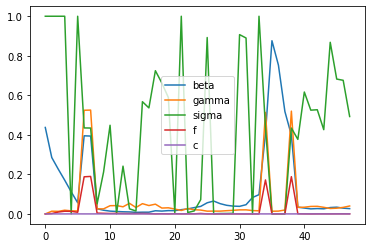

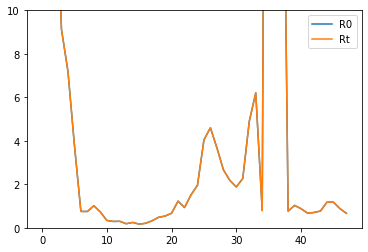

<ipython-input-97-fad03604a0b4>:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.plot(range(0, len(means["S0"])), np.array(means["S0"], dtype=np.float) * 10**-2)


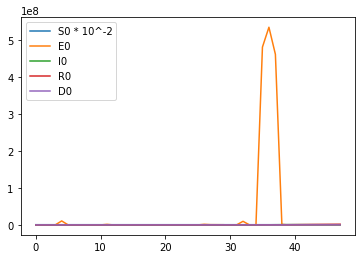

In [97]:
plt.plot(range(0, len(means["beta"])), means["beta"])
plt.plot(range(0, len(means["gamma"])), means["gamma"])
plt.plot(range(0, len(means["sigma"])), means["sigma"])
plt.plot(range(0, len(means["f"])), means["f"])
plt.plot(range(0, len(means["c"])), means["c"])

plt.legend(["beta", "gamma", "sigma", "f", "c"])
plt.show()

r0 = [means["beta"][i] / means["gamma"][i] for i in range(len(means["beta"]))]
rt = []
for i in range(len(r0)):
    n = dataset.iloc[i]["s"] + dataset.iloc[i]["i"] + dataset.iloc[i]["r"]
    s = dataset.iloc[i]["s"]
    rt.append(r0[i] * n / s)
plt.plot(range(0, len(r0)), r0)
plt.plot(range(0, len(rt)), rt)
plt.legend(["R0", "Rt"])
plt.ylim([0, 10])
plt.show()

plt.plot(range(0, len(means["S0"])), np.array(means["S0"], dtype=np.float) * 10**-2)
plt.plot(range(0, len(means["E0"])), means["E0"])
plt.plot(range(0, len(means["I0"])), means["I0"])
plt.plot(range(0, len(means["R0"])), means["R0"])
plt.plot(range(0, len(means["D0"])), means["D0"])


plt.legend(["S0 * 10^-2", "E0", "I0", "R0", "D0"])

plt.show()

In [98]:
print(means["E0"])

[140.15712428012753, 501.73772226021737, 1412.8703957782143, 4285.2027805103, 10747381.604402417, 4175.167865488722, 186373.9207846882, 207231.92006008368, 54704.67815547036, 8489.369377167144, 1141.4270048309647, 1501524.6770647352, 2431.7041970944115, 19298.92911825433, 21195.30304066052, 677.3375639026808, 8.063417772103038e-06, 2.126963694323297e-12, 6.524699448279531e-07, 0.02367445541544771, 39689.7959177003, 84.14872491027717, 43988.054919149086, 26760.145799948867, 7318.983450721704, 368.0662761350554, 1595039.6727469068, 744307.6248677017, 672058.2570842741, 554175.4624913529, 1404.1293451889803, 1324.7358733197395, 9738110.98944642, 5673.815091590778, 268005.9251437261, 480440001.9427884, 534048009.7329574, 460890001.93154824, 1435567.9205527266, 66317.08012590457, 20795.877153132962, 13792.937013004068, 18402.48859103421, 28494.97621161635, 9957.540349824581, 21799.153796417388, 19238.973557718957, 18517.598305708863]


In [99]:
predictions = {}
in_keys = my_seird.get_input_keys()
out_keys = my_seird.get_output_keys()
for i in range(len(dataset) // window_size):
    for k in range(len(in_keys)):
        my_seird.input_params[in_keys[k]] = means[in_keys[k]][i]
    tmp = my_seird.eval_series(window_size - 1)
    
    for k in range(len(out_keys)):
        if out_keys[k] not in predictions:
            predictions[out_keys[k]] = []
        predictions[out_keys[k]].extend(tmp[out_keys[k]])

        

total_rmse = 0
tmp = rmse(dataset["s"].iloc[:len(predictions["S"])].values, predictions["S"])
print("RMS on S0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["i"].iloc[:len(predictions["S"])].values, predictions["I"])
print("RMS on I0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["r"].iloc[:len(predictions["S"])].values, predictions["R"])
print("RMS on R0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["d"].iloc[:len(predictions["S"])].values, predictions["D"])
print("RMS on D0: {}".format(tmp))
total_rmse += tmp
print("Total RMSE: {}".format(total_rmse))

RMS on S0: 121892.43592301136
RMS on I0: 36305.25812231105
RMS on R0: 182396.4924818693
RMS on D0: 69092.69737024275
Total RMSE: 409686.88389743445


As it can be seen from the plots, the optimizer sometimes decides to make the number of exposed people rise substantially, in order to fit the known data. This is due to the complete freedom both on the exposed compartment and the rates which increase it (beta and sigma).

The fitting process is repeated after forcing a value for sigma close to the true incubation rate described in literature (8.2 to 15.6 days, CI = 97.5%, https://pubmed.ncbi.nlm.nih.gov/32150748/).

In [100]:
my_seird = models.HiddenSEIRD()

means = {}
variances = {}
for i in range(len(dataset) // window_size):
    print("Fitting window {}-{}...".format(i * window_size, (i+1) * window_size))
    x_data = np.array([j for j in range(window_size)], dtype=np.uint8)
    y_data = np.zeros((window_size, 4), dtype=np.float)
    for j in range(window_size):
        y_data[j,0] = dataset["s"].iloc[i * window_size + j]
        y_data[j,1] = dataset["i"].iloc[i * window_size + j]
        y_data[j,2] = dataset["r"].iloc[i * window_size + j]
        y_data[j,3] = dataset["d"].iloc[i * window_size + j]

    initial_guess = [dataset["s"].iloc[i * window_size], 2 * dataset["i"].iloc[i * window_size], dataset["i"].iloc[i * window_size], dataset["r"].iloc[i * window_size], dataset["d"].iloc[i * window_size], 0.5, 0.5, 1 / 12, 0, 0]
    vals, confidences = curve_fit(my_seird.f, x_data, y_data.flatten(), initial_guess, bounds=([0, 0, 0, 0, 0, 0, 0, 1 / 15.6, 0, 0], [dataset["s"].iloc[i * window_size], dataset["s"].iloc[i * window_size], dataset["s"].iloc[i * window_size], dataset["s"].iloc[i * window_size], dataset["s"].iloc[i * window_size], 1, 1, 1 / 8.2, 0.0001, 1]), maxfev=10000)
    keys = my_seird.get_input_keys()
    for k in range(len(keys)):
        my_seird.input_params[keys[k]] = vals[k]
        
    for k in range(len(keys)):
        if keys[k] not in means:
            means[keys[k]] = []
        means[keys[k]].append(vals[k])
        if keys[k] not in variances:
            variances[keys[k]] = []
        variances[keys[k]].append(confidences[k])


Fitting window 0-7...
Fitting window 7-14...
Fitting window 14-21...
Fitting window 21-28...
Fitting window 28-35...
Fitting window 35-42...


<ipython-input-100-d2b45c59d4db>:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_data = np.zeros((window_size, 4), dtype=np.float)


Fitting window 42-49...
Fitting window 49-56...
Fitting window 56-63...
Fitting window 63-70...
Fitting window 70-77...
Fitting window 77-84...
Fitting window 84-91...
Fitting window 91-98...
Fitting window 98-105...
Fitting window 105-112...
Fitting window 112-119...
Fitting window 119-126...
Fitting window 126-133...
Fitting window 133-140...
Fitting window 140-147...
Fitting window 147-154...
Fitting window 154-161...
Fitting window 161-168...
Fitting window 168-175...
Fitting window 175-182...
Fitting window 182-189...
Fitting window 189-196...
Fitting window 196-203...
Fitting window 203-210...
Fitting window 210-217...
Fitting window 217-224...
Fitting window 224-231...
Fitting window 231-238...
Fitting window 238-245...
Fitting window 245-252...
Fitting window 252-259...
Fitting window 259-266...
Fitting window 266-273...
Fitting window 273-280...
Fitting window 280-287...
Fitting window 287-294...
Fitting window 294-301...
Fitting window 301-308...
Fitting window 308-315...
Fit

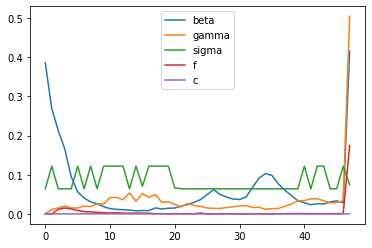

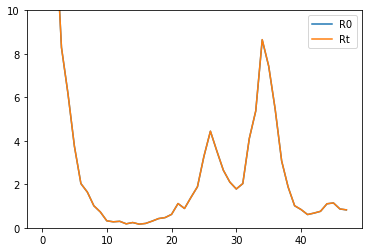

<ipython-input-101-fad03604a0b4>:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.plot(range(0, len(means["S0"])), np.array(means["S0"], dtype=np.float) * 10**-2)


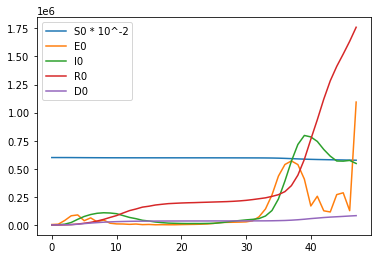

In [101]:
plt.plot(range(0, len(means["beta"])), means["beta"])
plt.plot(range(0, len(means["gamma"])), means["gamma"])
plt.plot(range(0, len(means["sigma"])), means["sigma"])
plt.plot(range(0, len(means["f"])), means["f"])
plt.plot(range(0, len(means["c"])), means["c"])

plt.legend(["beta", "gamma", "sigma", "f", "c"])
plt.show()

r0 = [means["beta"][i] / means["gamma"][i] for i in range(len(means["beta"]))]
rt = []
for i in range(len(r0)):
    n = dataset.iloc[i]["s"] + dataset.iloc[i]["i"] + dataset.iloc[i]["r"]
    s = dataset.iloc[i]["s"]
    rt.append(r0[i] * n / s)
plt.plot(range(0, len(r0)), r0)
plt.plot(range(0, len(rt)), rt)
plt.legend(["R0", "Rt"])
plt.ylim([0, 10])
plt.show()

plt.plot(range(0, len(means["S0"])), np.array(means["S0"], dtype=np.float) * 10**-2)
plt.plot(range(0, len(means["E0"])), means["E0"])
plt.plot(range(0, len(means["I0"])), means["I0"])
plt.plot(range(0, len(means["R0"])), means["R0"])
plt.plot(range(0, len(means["D0"])), means["D0"])


plt.legend(["S0 * 10^-2", "E0", "I0", "R0", "D0"])

plt.show()

In [102]:
print(means["E0"])

[3441.258873996129, 6442.153585736172, 39744.17187590793, 81375.64158998492, 89107.48388012961, 37437.57834565573, 62762.48559330655, 27728.347426820368, 43140.475569767645, 15135.794001370206, 9003.836069469078, 8170.87334004573, 5141.675798745308, 7817.833098747166, 2596.198118130163, 4129.820472875001, 1253.9593974840159, 2039.511180960272, 1296.1441293181458, 1434.0361188193783, 2958.0221805927927, 3992.5427302061885, 4866.028225025259, 6336.676048363114, 8309.994188349645, 13364.505952674353, 21149.588355434502, 22905.279322398856, 23679.303134797927, 25072.57581490166, 27202.46512465395, 36467.11403978009, 72215.69912031162, 142368.91041697917, 266772.0491154302, 435029.80590877985, 538170.6442181827, 569706.4578996744, 537448.2722046433, 407922.51822342374, 168741.8951120993, 255399.65219987812, 125669.65868022577, 115313.71852402593, 269874.7807113224, 286194.395971559, 126867.61407607568, 1094117.9655289862]


In [103]:
predictions = {}
in_keys = my_seird.get_input_keys()
out_keys = my_seird.get_output_keys()
for i in range(len(dataset) // window_size):
    for k in range(len(in_keys)):
        my_seird.input_params[in_keys[k]] = means[in_keys[k]][i]
    tmp = my_seird.eval_series(window_size - 1)
    
    for k in range(len(out_keys)):
        if out_keys[k] not in predictions:
            predictions[out_keys[k]] = []
        predictions[out_keys[k]].extend(tmp[out_keys[k]])

        

total_rmse = 0
tmp = rmse(dataset["s"].iloc[:len(predictions["S"])].values, predictions["S"])
print("RMS on S0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["i"].iloc[:len(predictions["S"])].values, predictions["I"])
print("RMS on I0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["r"].iloc[:len(predictions["S"])].values, predictions["R"])
print("RMS on R0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["d"].iloc[:len(predictions["S"])].values, predictions["D"])
print("RMS on D0: {}".format(tmp))
total_rmse += tmp
print("Total RMSE: {}".format(total_rmse))

RMS on S0: 48792.67687862056
RMS on I0: 47090.66130336263
RMS on R0: 60092.71081827959
RMS on D0: 24360.07339256245
Total RMSE: 180336.12239282523


In [104]:
seird_params = pd.DataFrame(means)
seird_params = seird_params.reset_index()
seird_params = seird_params.rename(columns={"index":"t"})
dates = (seird_params["t"] * window_size).to_list()
seird_params["data"] = df["data"][dates].to_list()


print(seird_params.head())

seird_params.to_csv("hidden_seird_params_weekly.csv")

   t            S0            E0            I0           R0           D0  \
0  0  5.999974e+07   3441.258874     79.810326    32.714234    18.571429   
1  1  5.999796e+07   6442.153586   1471.545565   297.691008   168.848110   
2  2  5.999083e+07  39744.171876   6701.932697   923.827891   700.549629   
3  3  5.997201e+07  81375.641590  21687.431120  2898.720701  2328.526934   
4  4  5.993549e+07  89107.483880  49902.781006  7641.194372  6167.989469   

       beta         gamma     sigma       c             f                data  
0  0.385722  2.611638e-10  0.064103  0.0001  1.626728e-25 2020-02-24 18:00:00  
1  0.268965  1.149797e-02  0.121951  0.0001  1.119969e-06 2020-03-02 18:00:00  
2  0.212813  1.503614e-02  0.064103  0.0001  1.160027e-02 2020-03-09 18:00:00  
3  0.166112  2.002944e-02  0.064103  0.0001  1.503978e-02 2020-03-16 17:00:00  
4  0.095095  1.538921e-02  0.064103  0.0001  1.284768e-02 2020-03-23 17:00:00  


0.093

In [105]:
my_seird = models.HiddenSEIRD()

means = {}
variances = {}
for i in range(len(dataset) // window_size):
    print("Fitting window {}-{}...".format(i * window_size, (i+1) * window_size))
    x_data = np.array([j for j in range(window_size)], dtype=np.uint8)
    y_data = np.zeros((window_size, 4), dtype=np.float)
    for j in range(window_size):
        y_data[j,0] = dataset["s"].iloc[i * window_size + j]
        y_data[j,1] = dataset["i"].iloc[i * window_size + j]
        y_data[j,2] = dataset["r"].iloc[i * window_size + j]
        y_data[j,3] = dataset["d"].iloc[i * window_size + j]

    initial_guess = [dataset["s"].iloc[i * window_size], 2 * dataset["i"].iloc[i * window_size], dataset["i"].iloc[i * window_size], dataset["r"].iloc[i * window_size], dataset["d"].iloc[i * window_size], 0.5, 0.5, 0.093, 0, 0]
    vals, confidences = curve_fit(my_seird.f, x_data, y_data.flatten(), initial_guess, bounds=([0, 0, 0, 0, 0, 0, 0, 0.083, 0, 0], [dataset["s"].iloc[i * window_size], dataset["s"].iloc[i * window_size], dataset["s"].iloc[i * window_size], dataset["s"].iloc[i * window_size], dataset["s"].iloc[i * window_size], 1, 1, 0.103, 0.0001, 1]), maxfev=10000)
    keys = my_seird.get_input_keys()
    for k in range(len(keys)):
        my_seird.input_params[keys[k]] = vals[k]
        
    for k in range(len(keys)):
        if keys[k] not in means:
            means[keys[k]] = []
        means[keys[k]].append(vals[k])
        if keys[k] not in variances:
            variances[keys[k]] = []
        variances[keys[k]].append(confidences[k])


Fitting window 0-7...
Fitting window 7-14...
Fitting window 14-21...
Fitting window 21-28...
Fitting window 28-35...
Fitting window 35-42...


<ipython-input-105-1c6a356ffd20>:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_data = np.zeros((window_size, 4), dtype=np.float)


Fitting window 42-49...
Fitting window 49-56...
Fitting window 56-63...
Fitting window 63-70...
Fitting window 70-77...
Fitting window 77-84...
Fitting window 84-91...
Fitting window 91-98...
Fitting window 98-105...
Fitting window 105-112...
Fitting window 112-119...
Fitting window 119-126...
Fitting window 126-133...
Fitting window 133-140...
Fitting window 140-147...
Fitting window 147-154...
Fitting window 154-161...
Fitting window 161-168...
Fitting window 168-175...
Fitting window 175-182...
Fitting window 182-189...
Fitting window 189-196...
Fitting window 196-203...
Fitting window 203-210...
Fitting window 210-217...
Fitting window 217-224...
Fitting window 224-231...
Fitting window 231-238...
Fitting window 238-245...
Fitting window 245-252...
Fitting window 252-259...
Fitting window 259-266...
Fitting window 266-273...
Fitting window 273-280...
Fitting window 280-287...
Fitting window 287-294...
Fitting window 294-301...
Fitting window 301-308...
Fitting window 308-315...
Fit

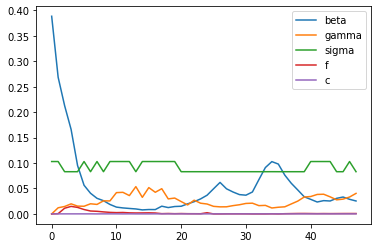

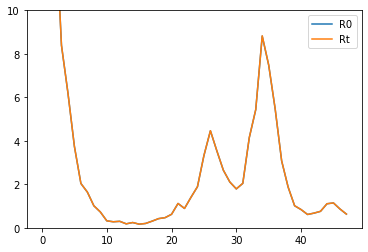

<ipython-input-106-fad03604a0b4>:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.plot(range(0, len(means["S0"])), np.array(means["S0"], dtype=np.float) * 10**-2)


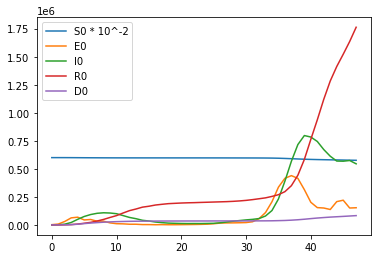

In [106]:
plt.plot(range(0, len(means["beta"])), means["beta"])
plt.plot(range(0, len(means["gamma"])), means["gamma"])
plt.plot(range(0, len(means["sigma"])), means["sigma"])
plt.plot(range(0, len(means["f"])), means["f"])
plt.plot(range(0, len(means["c"])), means["c"])

plt.legend(["beta", "gamma", "sigma", "f", "c"])
plt.show()

r0 = [means["beta"][i] / means["gamma"][i] for i in range(len(means["beta"]))]
rt = []
for i in range(len(r0)):
    n = dataset.iloc[i]["s"] + dataset.iloc[i]["i"] + dataset.iloc[i]["r"]
    s = dataset.iloc[i]["s"]
    rt.append(r0[i] * n / s)
plt.plot(range(0, len(r0)), r0)
plt.plot(range(0, len(rt)), rt)
plt.legend(["R0", "Rt"])
plt.ylim([0, 10])
plt.show()

plt.plot(range(0, len(means["S0"])), np.array(means["S0"], dtype=np.float) * 10**-2)
plt.plot(range(0, len(means["E0"])), means["E0"])
plt.plot(range(0, len(means["I0"])), means["I0"])
plt.plot(range(0, len(means["R0"])), means["R0"])
plt.plot(range(0, len(means["D0"])), means["D0"])


plt.legend(["S0 * 10^-2", "E0", "I0", "R0", "D0"])

plt.show()

In [107]:
predictions = {}
in_keys = my_seird.get_input_keys()
out_keys = my_seird.get_output_keys()
for i in range(len(dataset) // window_size):
    for k in range(len(in_keys)):
        my_seird.input_params[in_keys[k]] = means[in_keys[k]][i]
    tmp = my_seird.eval_series(window_size - 1)
    
    for k in range(len(out_keys)):
        if out_keys[k] not in predictions:
            predictions[out_keys[k]] = []
        predictions[out_keys[k]].extend(tmp[out_keys[k]])

        

total_rmse = 0
tmp = rmse(dataset["s"].iloc[:len(predictions["S"])].values, predictions["S"])
print("RMS on S0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["i"].iloc[:len(predictions["S"])].values, predictions["I"])
print("RMS on I0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["r"].iloc[:len(predictions["S"])].values, predictions["R"])
print("RMS on R0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["d"].iloc[:len(predictions["S"])].values, predictions["D"])
print("RMS on D0: {}".format(tmp))
total_rmse += tmp
print("Total RMSE: {}".format(total_rmse))

RMS on S0: 1253.0477832615481
RMS on I0: 2244.1365943238357
RMS on R0: 2049.844937378299
RMS on D0: 176.17243116857924
Total RMSE: 5723.201746132263


In [108]:
seird_params = pd.DataFrame(means)
seird_params = seird_params.reset_index()
seird_params = seird_params.rename(columns={"index":"t"})
dates = (seird_params["t"] * window_size).to_list()
seird_params["data"] = df["data"][dates].to_list()


print(seird_params.head())

seird_params.to_csv("hidden_seird_params_weekly_fixed_sigma.csv")

   t            S0            E0            I0           R0           D0  \
0  0  5.999975e+07   2184.003636     84.210083    32.714202    18.571429   
1  1  5.999796e+07   7646.437269   1463.787914   293.132205   164.724056   
2  2  5.999083e+07  30738.099873   6713.405983   937.169060   713.905789   
3  3  5.997202e+07  62905.723028  21703.957035  2918.146718  2348.128034   
4  4  5.993550e+07  68954.898510  49901.973001  7649.039990  6175.847390   

       beta         gamma     sigma       c             f                data  
0  0.388663  3.867354e-35  0.102998  0.0001  2.280091e-37 2020-02-24 18:00:00  
1  0.268703  1.207166e-02  0.103000  0.0001  5.128009e-04 2020-03-02 18:00:00  
2  0.212876  1.460213e-02  0.083000  0.0001  1.116793e-02 2020-03-09 18:00:00  
3  0.166153  1.979718e-02  0.083000  0.0001  1.480725e-02 2020-03-16 17:00:00  
4  0.095105  1.534211e-02  0.083000  0.0001  1.280065e-02 2020-03-23 17:00:00  
